<a href="https://colab.research.google.com/github/abarankab/tinkoff_notebooks/blob/master/computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5907a000 @  0x7f384905f2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import torch
from torchvision import models, transforms
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops
import numpy as np
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
%matplotlib inline

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import cv2

In [0]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig i965-va-driver libaacs0 libasound2 libasound2-data libass9
  libasyncns0 libavc1394-0 libavcodec57 libavdevice57 libavfilter6
  libavformat57 libavresample3 libavutil55 libbdplus0 libbluray2 libbs2b0
  libcaca0 libcairo2 libcdio-cdda2 libcdio-paranoia2 libcdio17 libchromaprint1
  libcroco3 libcrystalhd3 libdatrie1 libdc1394-22 libdrm-amdgpu1 libdrm-intel1
  libdrm-nouveau2 libdrm-radeon1 libfftw3-double3 libflac8 libflite1
  libfribidi0 libgdk-pixbuf2.0-0 libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-common
  libgl1 libgl1-mesa-dri libglx-mesa0 libglx0 libgme0 libgsm1 libiec61883-0
  libjack-jackd2-0 libjbig0 libllvm6.0 libmp3lame0 libmpg123-0 libmysofa0
  libnuma1 libogg0 libopenal-data libopenal1 libopenjp2-7 libopenmpt0 libopus0
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpciaccess0
  libpixman-1-0 libpostproc54 libpu

In [0]:
!which ffmpeg
plt.rcParams['animation.ffmpeg_path'] = u'/usr/bin/ffmpeg'

/usr/bin/ffmpeg


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
cnn = models.vgg16(pretrained=True).eval().to(device)
tt = transforms.ToTensor()
ti = transforms.ToPILImage()
hglob = []

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 77640652.24it/s]


In [0]:
!wget https://www.artistsnetwork.com/wp-content/uploads/importedmedia/DT1854.jpg
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSe8Jz9HWznGSe5UmiA7aTpyr4h0ZbU6kMaNVtLoe1bzXJePHXG
!ls

--2018-11-28 18:56:26--  https://www.artistsnetwork.com/wp-content/uploads/importedmedia/DT1854.jpg
Resolving www.artistsnetwork.com (www.artistsnetwork.com)... 52.85.219.72, 52.85.219.18, 52.85.219.247, ...
Connecting to www.artistsnetwork.com (www.artistsnetwork.com)|52.85.219.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181006 (177K) [image/jpeg]
Saving to: ‘DT1854.jpg’

DT1854.jpg          100%[===================>] 176.76K  1009KB/s    in 0.2s    

2018-11-28 18:56:27 (1009 KB/s) - ‘DT1854.jpg’ saved [181006/181006]

--2018-11-28 18:56:28--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSe8Jz9HWznGSe5UmiA7aTpyr4h0ZbU6kMaNVtLoe1bzXJePHXG
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 108.177.15.139, 108.177.15.102, 108.177.15.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|108.177.15.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4058 (4.0K) [image/jpeg]
Savin

In [0]:
transformMean = [0.485, 0.456, 0.406]
transformStd = [0.229, 0.224, 0.225]
transformNormalise = transforms.Normalize(
    mean=transformMean,
    std=transformStd
)
  
transformPreprocess = transforms.Compose([
    transformNormalise
])
tensorStd = torch.Tensor(transformStd).to(device)
tensorMean = torch.Tensor(transformMean).to(device)

def toImage(input):
  input.transpose_(0, 1)
  input.transpose_(1, 2)
  input = input * tensorStd + tensorMean
  input.transpose_(1, 2)
  input.transpose_(0, 1)
  return input

In [0]:
len(cnn(torch.ones(1, 3, 224, 224).to(device))[0])
device

device(type='cuda')

In [0]:
def dream(image, iterations, lr, label):
  
  history = []
  #image = transformPreprocess(image).unsqueeze(0).requires_grad_()
  image = image.unsqueeze(0).requires_grad_()
  
  history.append(image.data.squeeze())
  history[-1] = ti(toImage(history[-1]).cpu())
  plt.axis('off')
  plt.imshow(history[-1])
  plt.show()
  
  weight = [1] * 1000
  weight[label] = -100
  weight = torch.Tensor(weight).to(device)

  for _ in range(iterations):
    print(_, 'start')
    
    result = cnn(image).to(device)
    #probs = F.log_softmax(cnn(image), dim=1)
    #y = torch.LongTensor([label]).to(device)
    #loss = torch.nn.NLLLoss()(probs, y)
    loss = (result * weight).norm()
    loss.backward()
    
    image.data = image.data - lr * image.grad.data / image.grad.data.norm()
    image.data = torch.clamp(image.data, min=0, max=1)
    
    history.append(image.data.squeeze())
    #history[-1] = ti(toImage(history[-1]).cpu())
    history[-1] = ti(history[-1].cpu())
    
    plt.axis('off')
    plt.imshow(history[-1])
    plt.show()
    
    print(_, 'done')

  return history

In [0]:
!wget http://sch-int.ru/wp-content/themes/school/images/header/logo.png

--2018-11-28 18:56:54--  http://sch-int.ru/wp-content/themes/school/images/header/logo.png
Resolving sch-int.ru (sch-int.ru)... 195.208.0.127
Connecting to sch-int.ru (sch-int.ru)|195.208.0.127|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5519 (5.4K) [image/png]
Saving to: ‘logo.png’

logo.png            100%[===================>]   5.39K  --.-KB/s    in 0s      

2018-11-28 18:56:54 (399 MB/s) - ‘logo.png’ saved [5519/5519]



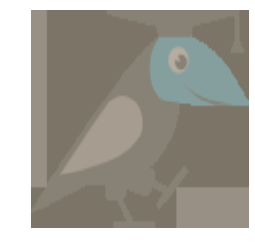

0 start


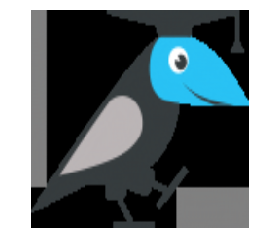

0 done
1 start


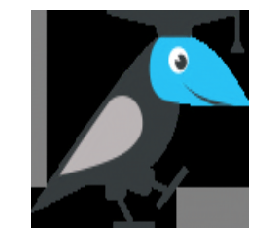

1 done
2 start


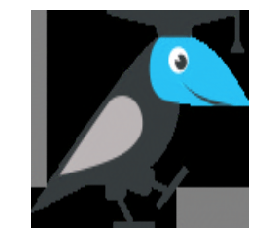

2 done
3 start


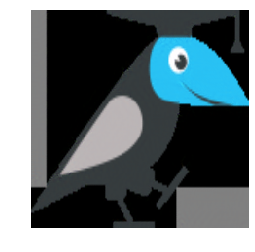

3 done
4 start


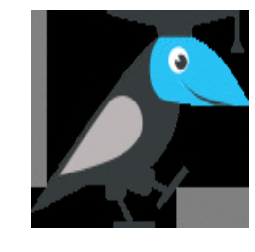

4 done
5 start


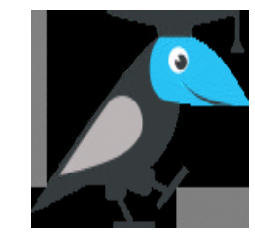

5 done
6 start


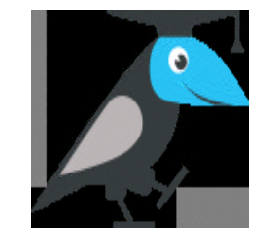

6 done
7 start


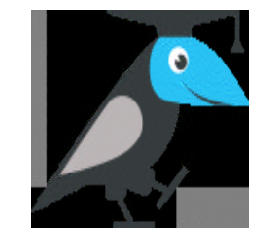

7 done
8 start


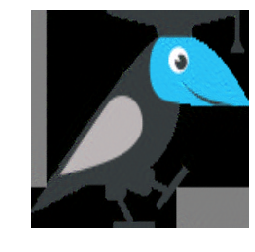

8 done
9 start


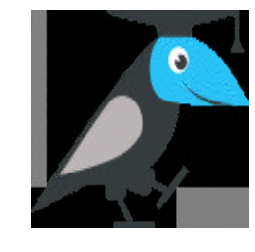

9 done
10 start


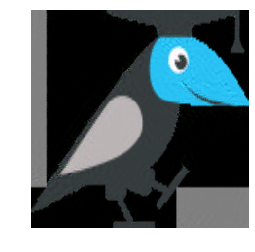

10 done
11 start


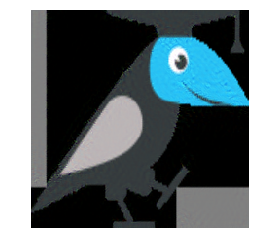

11 done
12 start


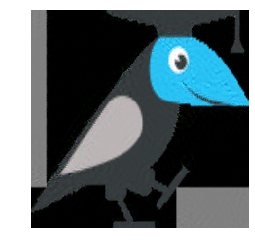

12 done
13 start


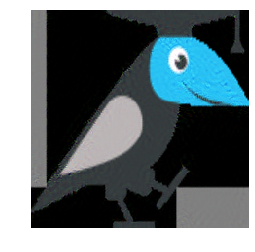

13 done
14 start


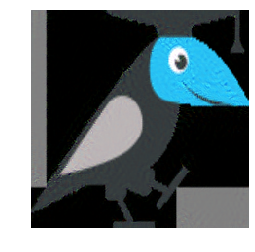

14 done
15 start


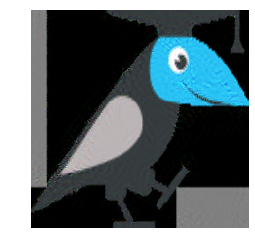

15 done
16 start


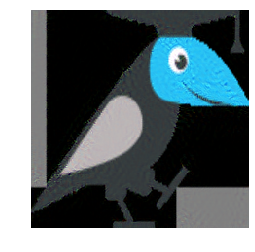

16 done
17 start


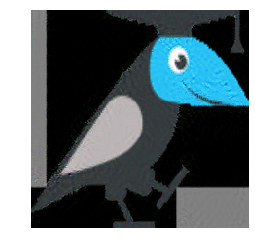

17 done
18 start


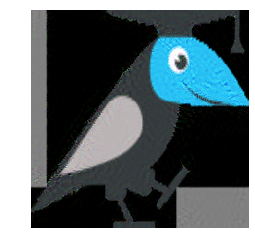

18 done
19 start


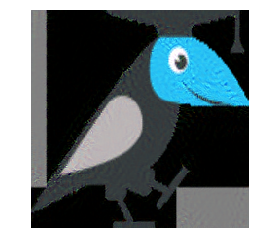

19 done
20 start


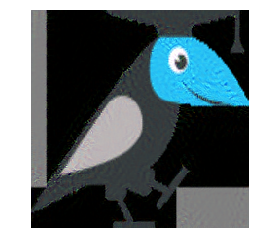

20 done
21 start


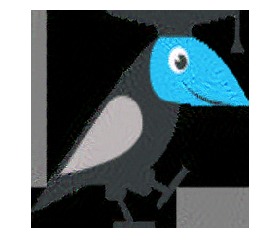

21 done
22 start


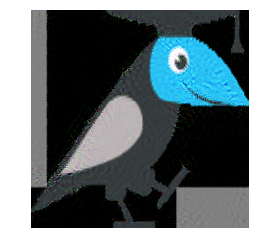

22 done
23 start


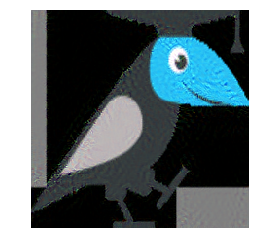

23 done
24 start


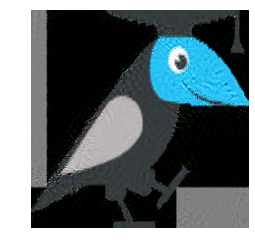

24 done
25 start


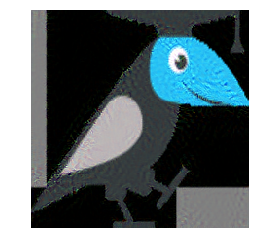

25 done
26 start


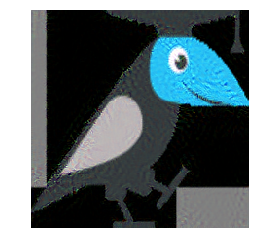

26 done
27 start


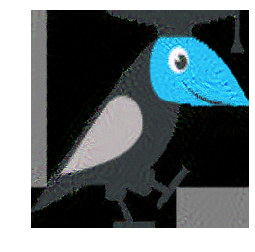

27 done
28 start


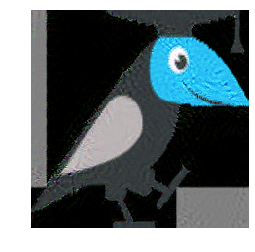

28 done
29 start


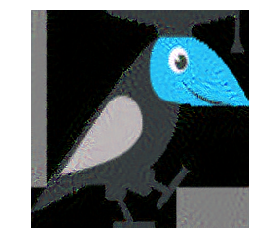

29 done
30 start


In [0]:
im = cv2.imread('logo.png')
im = cv2.resize(im, (224, 224))
#im = im[10:234, 10:234, :]
im = tt(im).to(device)
history = dream(image=im, iterations=500, lr=0.5, label=308)

In [0]:
input = torch.ones(3, 224, 224).to(device)
history = dream(image=input, iterations=1000, lr=0.2, label=383)

In [0]:
hglob.append(history)

In [0]:
def pre(img):
  pic = img
  plt.axis('off')
  return plt.imshow(pic, animated=True)

def morph(inputs, delay):
  fig = plt.figure()
  images = []
  for q in inputs:
    images.append([pre(q)])

  ani = animation.ArtistAnimation(fig, images, interval=delay)

  display(HTML(ani.to_html5_video()))

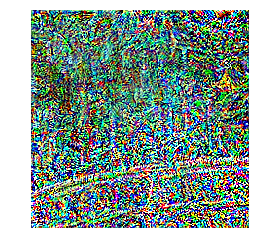

In [0]:
for h in hglob:
  morph(h, 100)

In [0]:
prob = []
tt = transforms.ToTensor()
for img in hglob[-2]:
  tensor = tt(img).unsqueeze(0)
  prob.append(cnn(tensor)[0][963].data)
  print(prob)

NameError: ignored

In [0]:
%matplotlib inline
print(prob)
pyplot.show(prob)

[tensor(-1.8581), tensor(-1.5399), tensor(-0.4879), tensor(-0.3085), tensor(0.3554), tensor(0.0236), tensor(0.9470), tensor(0.8343), tensor(2.3586), tensor(3.4574), tensor(3.1992), tensor(4.4184), tensor(5.5120), tensor(4.8417), tensor(7.6348), tensor(8.0079), tensor(9.4236), tensor(12.2864), tensor(12.0799), tensor(13.8086), tensor(13.6853), tensor(15.4893), tensor(13.6546), tensor(17.1065), tensor(15.5516), tensor(20.2865), tensor(17.9801), tensor(19.4254), tensor(20.4175), tensor(20.1542), tensor(21.6579), tensor(21.3335), tensor(25.3480), tensor(22.5649), tensor(25.7167), tensor(23.5350), tensor(26.1803), tensor(25.3061), tensor(28.1629), tensor(26.7108), tensor(28.2949), tensor(27.3384), tensor(26.8891), tensor(26.0947), tensor(27.1651), tensor(30.0218), tensor(31.2474), tensor(28.9034), tensor(33.2431), tensor(31.1756), tensor(33.3044), tensor(31.7782), tensor(33.2837), tensor(33.1820), tensor(35.8744), tensor(33.1776), tensor(34.7457), tensor(35.1758), tensor(35.1049), tensor(35

--2018-11-18 13:26:18--  https://www.artistsnetwork.com/wp-content/uploads/importedmedia/DT1854.jpg
Resolving www.artistsnetwork.com (www.artistsnetwork.com)... 13.33.155.104, 13.33.155.187, 13.33.155.200, ...
Connecting to www.artistsnetwork.com (www.artistsnetwork.com)|13.33.155.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181006 (177K) [image/jpeg]
Saving to: ‘DT1854.jpg’

DT1854.jpg          100%[===================>] 176.76K  --.-KB/s    in 0.02s   

2018-11-18 13:26:19 (6.95 MB/s) - ‘DT1854.jpg’ saved [181006/181006]

DT1854.jpg  sample_data


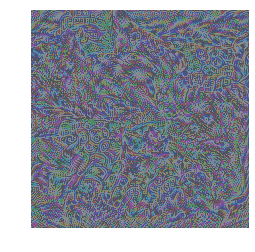

In [0]:
morph(history, 100)